<a href="https://colab.research.google.com/github/USobumuneme/ABC-Phonics-Adventure/blob/main/Monitoring_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
# Load the dataset
file_path = "/content/dataset2.csv"  # Adjust path as needed
df = pd.read_csv(file_path)


In [ ]:
# Fix column names
df.columns = [col.replace("\u00c2", "").strip() for col in df.columns]

In [ ]:
# Create target: collapse_risk
collapse_threshold_hr = 180
collapse_threshold_temp = 37 #39.5
df['collapse_risk'] = np.where(
    (df['heart_rate'] > collapse_threshold_hr) |
    (df['chest temperature (°C)'] > collapse_threshold_temp), 1, 0
)

In [ ]:
# prompt: save the dataset with the new column collapse_risk

# Save the DataFrame with the new 'collapse_risk' column to a CSV file.
df.to_csv("/content/dataset2_with_collapse_risk.csv", index=False)


In [ ]:
# Drop identifiers
df = df.drop(columns=['PeopleId', 'activityID'])

In [ ]:
# Handle missing values
df.fillna(df.mean(), inplace=True)

In [ ]:
# Split features and target
X = df.drop(columns=['collapse_risk'])
y = df['collapse_risk']

In [ ]:
total_records = len(df)
print(f"Total number of records: {total_records}")

Total number of records: 266539


In [ ]:
# Check the unique values and their types
print("Unique values in collapse_risk:")
print(df['collapse_risk'].unique())

# Count values including all types, forcing conversion to numeric (handles ' 1' etc.)
df['collapse_risk'] = pd.to_numeric(df['collapse_risk'], errors='coerce')

# Now display counts again
count = df['collapse_risk'].value_counts(dropna=False)
print("\nCollapse Risk Counts (after cleaning):")
print(count)

Unique values in collapse_risk:
[0 1]

Collapse Risk Counts (after cleaning):
collapse_risk
0    218941
1     47598
Name: count, dtype: int64


In [ ]:
from matplotlib.ticker import ScalarFormatter

<ipython-input-11-b87dd5b4459f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='collapse_risk', palette= 'Set2')
<ipython-input-11-b87dd5b4459f>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No Risk', 'At Risk'])


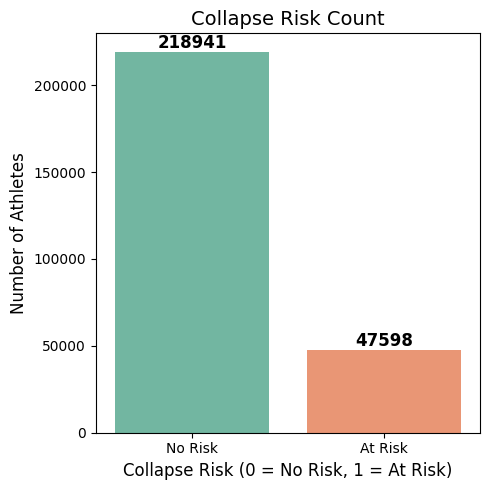

In [ ]:
# Count plot for collapse_risk
plt.figure(figsize=(5, 5))
ax = sns.countplot(data=df, x='collapse_risk', palette= 'Set2')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize axes and title
ax.set_title('Collapse Risk Count', fontsize=14)
ax.set_xlabel('Collapse Risk (0 = No Risk, 1 = At Risk)', fontsize=12)
ax.set_ylabel('Number of Athletes', fontsize=12)
ax.set_xticklabels(['No Risk', 'At Risk'])
plt.tight_layout()
plt.show()

In [ ]:
# Scale features for LSTM
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# 1. Set PYTHONHASHSEED environment variable
os.environ['PYTHONHASHSEED'] = '42'

# 2. Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# Random Forest
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(  n_estimators=100,
    max_depth=10,              # Limit depth to prevent overfitting
    min_samples_split=10,      # Require more samples to split a node
    min_samples_leaf=5,        # Force leaf nodes to have more samples
    max_features='sqrt',       # Random subset of features
    random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_model.predict(X_test_rf)
print("Random Forest Classification Report:\n", classification_report(y_test_rf, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     68452
           1       1.00      1.00      1.00     28874

    accuracy                           1.00     97326
   macro avg       1.00      1.00      1.00     97326
weighted avg       1.00      1.00      1.00     97326



In [ ]:
print("Training Accuracy:", rf_model.score(X_train_rf, y_train_rf))

Training Accuracy: 1.0


In [ ]:
df = pd.concat([X, y], axis=1)
correlations = df.corr(numeric_only=True)[y.name].sort_values(ascending=False)

print("Top correlated features with the target:\n", correlations.head(10))

Top correlated features with the target:
 collapse_risk                1.000000
chest temperature (°C)       0.403064
ankle temperature (°C)       0.300551
hand magnetometer X          0.161515
hand temperature (°C)        0.144825
ankle acceleration X ±16g    0.124693
heart_rate                   0.096998
chest acceleration Y ±16g    0.095723
chest magnetometer Z         0.065111
hand magnetometer Z          0.056861
Name: collapse_risk, dtype: float64


In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,              # Limit depth to prevent overfitting
    min_samples_split=10,      # Require more samples to split a node
    min_samples_leaf=5,        # Force leaf nodes to have more samples
    max_features='sqrt',       # Random subset of features
    random_state=42)

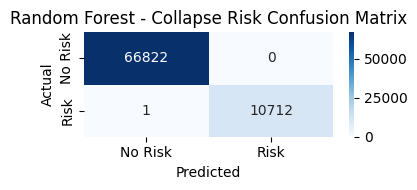

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(4,2))
sns.heatmap(confusion_matrix(y_test_rf, y_pred_rf), annot=True, fmt='d', cmap='Blues', xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.title("Random Forest - Collapse Risk Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
# LSTM expects 3D input: (samples, time steps, features)
# For simplicity, reshape X as time series with 1 timestep
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
#y = y.to_numpy() if isinstance(y, pd.Series) else y
# Check if y has only 1 dimension
#if y.ndim == 1:
    # Reshape to (num_samples, 1)
    #y = y.reshape(-1, 1)
y_lstm = to_categorical(y)

In [ ]:
# Split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)


In [ ]:
# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_lstm.shape[1], X_lstm.shape[2]), return_sequences=False))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(2, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
6664/6664 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9307 - loss: 0.1693 - val_accuracy: 0.9812 - val_loss: 0.0571
Epoch 2/5
6664/6664 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9739 - loss: 0.0683 - val_accuracy: 0.9799 - val_loss: 0.0523
Epoch 3/5
6664/6664 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9788 - loss: 0.0554 - val_accuracy: 0.9880 - val_loss: 0.0316
Epoch 4/5
6664/6664 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9823 - loss: 0.0457 - val_accuracy: 0.9860 - val_loss: 0.0378
Epoch 5/5
6664/6664 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.9845 - loss: 0.0403 - val_accuracy: 0.9835 - val_loss: 0.0366


In [ ]:
# Evaluate LSTM
lstm_scores = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print("\nLSTM Accuracy: {:.2f}%".format(lstm_scores[1] * 100))



LSTM Accuracy: 98.35%


In [ ]:
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)
# Get predicted labels by selecting the class with the highest probability
y_pred_labels = np.argmax(y_pred_lstm, axis=1)
# y_test_lstm.argmax(axis=1) already gives you the true labels
print("\nLSTM:\n", classification_report(y_test_lstm.argmax(axis=1), y_pred_labels))

1666/1666 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

LSTM:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     43679
           1       0.92      1.00      0.96      9629

    accuracy                           0.98     53308
   macro avg       0.96      0.99      0.97     53308
weighted avg       0.98      0.98      0.98     53308



In [ ]:
from sklearn.metrics import classification_report

# Print classification report with 4 decimal places
report = classification_report(y_test_lstm.argmax(axis=1), y_pred_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nLSTM:\n", df_report.round(4))


LSTM:
               precision  recall  f1-score     support
0                0.9994  0.9804    0.9898  43679.0000
1                0.9182  0.9973    0.9561   9629.0000
accuracy         0.9835  0.9835    0.9835      0.9835
macro avg        0.9588  0.9889    0.9730  53308.0000
weighted avg     0.9847  0.9835    0.9837  53308.0000


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_lstm.argmax(axis=1), lstm_model.predict(X_test_lstm).argmax(axis=1)) # Use y_test_lstm instead of y_test and X_test_lstm instead of X_test
print(cm)

1666/1666 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
[[42824   855]
 [   26  9603]]


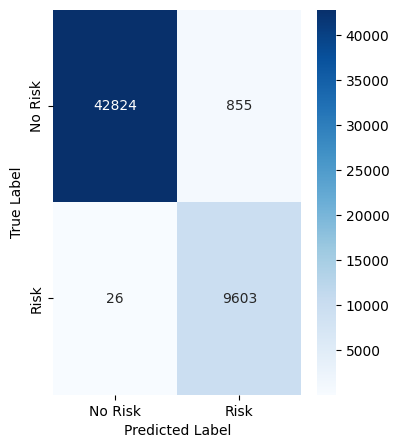

In [ ]:
# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(4, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Epoch 1/5
6664/6664 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.9852 - loss: 0.0369 - val_accuracy: 0.9902 - val_loss: 0.0269
Epoch 2/5
6664/6664 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9867 - loss: 0.0339 - val_accuracy: 0.9810 - val_loss: 0.0498
Epoch 3/5
6664/6664 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9879 - loss: 0.0316 - val_accuracy: 0.9871 - val_loss: 0.0306
Epoch 4/5
6664/6664 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.9885 - loss: 0.0296 - val_accuracy: 0.9919 - val_loss: 0.0206
Epoch 5/5
6664/6664 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9886 - loss: 0.0296 - val_accuracy: 0.9908 - val_loss: 0.0228


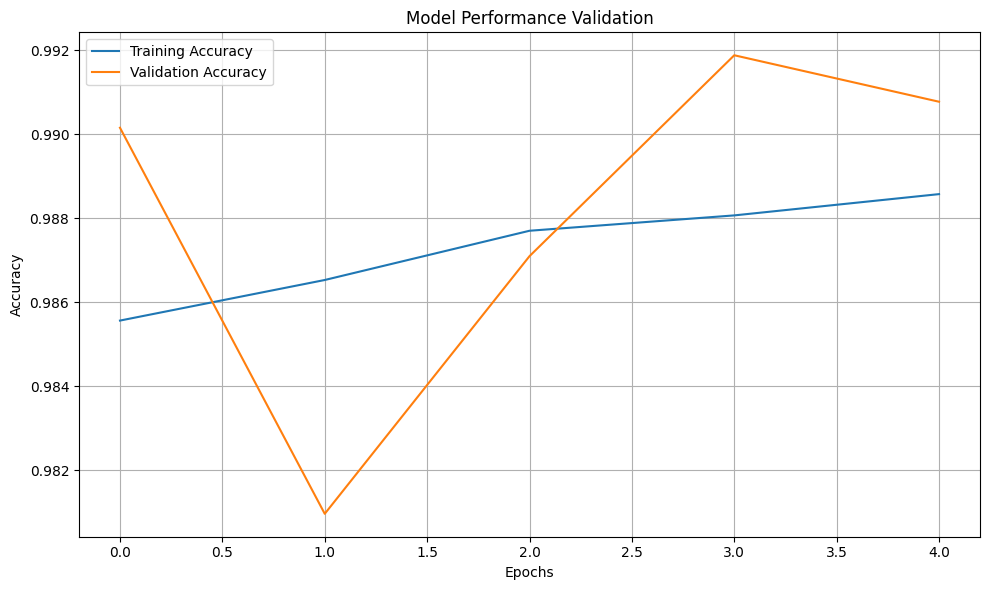

In [ ]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Assign the output of fit to history
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

# Plotting training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Performance Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Finetune LSTM threshold by adjusting classification threshold (e.g., 0.45 instead of 0.5) to catch more risky cases
#Predict probabilities instead of class labels
y_probs = lstm_model.predict(X_test_lstm) # Assuming you want to use the LSTM model

# Apply custom threshold
threshold = 0.45
y_pred_adjusted = (y_probs[:,1] > threshold).astype(int) # Access the probability of class 1

# Now evaluate
from sklearn.metrics import classification_report, confusion_matrix

# Get the classification report as a dictionary
report = classification_report(y_test_lstm.argmax(axis=1), y_pred_adjusted, output_dict=True)

# Convert the dictionary to a DataFrame for easier rounding
df_report = pd.DataFrame(report).transpose()

# Round the numerical values in the DataFrame
df_report = df_report.round(4)

# Print the rounded DataFrame
print(df_report)

print(confusion_matrix(y_test_lstm.argmax(axis=1), y_pred_adjusted))

1666/1666 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision  recall  f1-score     support
0                0.9991  0.9889    0.9939  43679.0000
1                0.9519  0.9957    0.9733   9629.0000
accuracy         0.9901  0.9901    0.9901      0.9901
macro avg        0.9755  0.9923    0.9836  53308.0000
weighted avg     0.9905  0.9901    0.9902  53308.0000
[[43194   485]
 [   41  9588]]


In [ ]:
from sklearn.metrics import classification_report

# Print classification report with 4 decimal places
report = classification_report(y_test_lstm.argmax(axis=1), y_pred_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nLSTM:\n", df_report.round(4))

In [ ]:
# Save the model
lstm_model.save("athlete_lstm_model.h5")
print("✅ LSTM model saved as 'athlete_lstm_model.h5'")

✅ LSTM model saved as 'athlete_lstm_model.h5'


In [ ]:
cm = confusion_matrix(y_test_lstm.argmax(axis=1), y_pred_adjusted)  # Use y_pred_adjusted directly
print(cm)

[[68161   291]
 [  449 28425]]


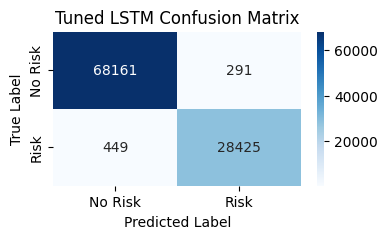

In [ ]:
# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.title("Tuned LSTM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import smtplib
from keras.models import load_model
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import time

# Load your trained LSTM model
model = load_model("athlete_lstm_model.h5")

# Set classification threshold
THRESHOLD = 0.45

# Email settings
EMAIL_SENDER = "your_email@gmail.com"
EMAIL_PASSWORD = "your_app_password"
EMAIL_RECEIVER = "recipient_email@example.com"
SMTP_SERVER = "smtp.gmail.com"
SMTP_PORT = 587

# Alert function
def send_alert(probability):
    subject = "⚠️ Athlete Collapse Risk Detected!"
    body = f"""
    Alert: High risk of athlete collapse detected!
    Risk Probability: {probability:.2f}
    Action: Immediate medical attention is advised.
    """

    msg = MIMEMultipart()
    msg['From'] = EMAIL_SENDER
    msg['To'] = EMAIL_RECEIVER
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    try:
        server = smtplib.SMTP(SMTP_SERVER, SMTP_PORT)
        server.starttls()
        server.login(EMAIL_SENDER, EMAIL_PASSWORD)
        server.sendmail(EMAIL_SENDER, EMAIL_RECEIVER, msg.as_string())
        server.quit()
        print("✅ Alert sent!")
    except Exception as e:
        print(f"❌ Failed to send alert: {e}")

# Simulate live data stream (replace with live wearable sensor feed)
def live_data_generator(csv_path):
    df = pd.read_csv(csv_path)
    features = df.drop(columns=["collapse_risk", "PeopleId", "activityID"], errors="ignore")
    for _, row in features.iterrows():
        yield np.expand_dims(row.values, axis=0)  # Reshape for LSTM input

# Monitoring loop
def monitor_system(csv_path):
    print("🟢 Real-time monitoring started...")
    for data in live_data_generator(csv_path):
        prediction = model.predict(data, verbose=0)
        probability = prediction[0][0]
        print(f"Predicted Risk: {probability:.4f}")
        if probability > THRESHOLD:
            send_alert(probability)
        time.sleep(1)  # simulate 1-second interval between readings

# Run the monitoring system
if __name__ == "__main__":
    monitor_system("sport.csv")  # replace with your actual streaming data source
